# Softmax Regression


# Image Classification on Fashion-MNIST

Before we implement softmax regression ourselves, let's pick a real dataset to work with. To make things visually compelling, we will pick an image classification dataset. The most commonly used image classification data set is the [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit recognition data set, proposed by LeCun, Cortes and Burges in the 1990s. However, even simple models achieve classification accuracy over 95% on MNIST, so it is hard to spot the differences between better models and weaker ones. In order to get a better intuition, we will use the qualitatively similar, but comparatively complex [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, proposed by [Xiao, Rasul and Vollgraf](https://arxiv.org/abs/1708.07747) in 2017.

## Getting the Data

First, import the packages or modules required in this section.



In [ ]:
%matplotlib inline
import sys
sys.path.insert(0, '..')

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import time

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

Conveniently, PyTorch's `torchvision.datasets` package provides easy access to a number of benchmark vision datasets for testing our models.
The first time we invoke `data.vision.FashionMNIST(train=True)`
to collect the training data,
PyTorch will automatically retrieve the dataset via our Internet connection.
Subsequently, PyTorch will use the already-downloaded local copy.
We specify whether we are requesting the training set or the test set
by setting the value of the parameter `train` to `True` or `False`, respectively.
Recall that we will only be using the training data for training,
holding out the test set for a final evaluation of our model.

In [ ]:
# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = transforms.ToTensor() 

The `ToTensor` Transform also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations introduced later.

In [ ]:
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

0.0%

100.0%


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw


27.8%

100.6%
0.3%

Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



119.3%


Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



The number of images for each category in the training set and the testing set is 6,000 and 1,000, respectively. Since there are 10 categories, the numbers of examples in the training set and the test set are 60,000 and 10,000, respectively.

In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

We can access any example by indexing into the dataset using square brackets `[]`. In the following code, we access the image and label corresponding to the first example.

In [ ]:
feature, label = mnist_train[0]  # accessing the first example in the training set

Our example, stored here in the variable `feature` corresponds to an image with a height and width of 28 pixels. PyTorch automatically scales it into a tensor with each pixel value between 0 and 1. It is stored in a 3D Tensor. Its first dimension is the number of channels. Since the data set is a grayscale image, the number of channels is 1. When we encounter color, images, we'll have 3 channels for red, green, and blue. To keep things simple, we will record the shape of the image with the height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.

In [ ]:
feature.shape, feature.dtype

(torch.Size([1, 28, 28]), torch.float32)

The label of each image is represented as a scalar in PyTorch. Its type is a 64-bit integer.

In [ ]:
label, type(label)

(9, int)

There are 10 categories in Fashion-MNIST: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. The following function can convert a numeric label into a corresponding text label.

In [ ]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

The following defines a function that can draw multiple images and corresponding labels in a single line.

In [ ]:
def show_fashion_mnist(images, labels):    
    # Here _ means that we ignore (not use) variables
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

In [ ]:
batch_size = 256
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

Next, let's take a look at the image contents and text labels for the first nine examples in the training data set.

Note: PyTorch DataLoader objects don't support regular array slicing. You can instead iterate through.

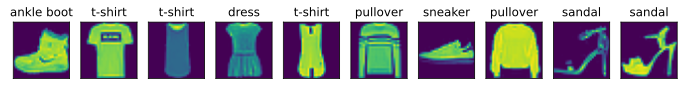

In [ ]:
X=[]
y=[]
for idx, data in enumerate(mnist_train):
    if(idx>=0 and idx<10):
        X.append(data[0])
        y.append(data[1])
    if (idx>=10):
        break
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## Reading a Minibatch

To make our life easier when reading from the training and test sets we use a `DataLoader` rather than creating one from scratch, as we did in `chapter_linear_scratch`. Recall that a data loader reads a mini-batch of data with an example number of `batch_size` each time.

In practice, reading data can often be a significant performance bottleneck for training, especially when the model is simple or when the computer is fast. A handy feature of PyTorch's `DataLoader` is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via `num_workers`).

We've already applied required transformations before.

Let's look at the time it takes to read all the training data.

In [ ]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'8.95 sec'

# Implementation of Softmax Regression from Scratch

:label:`chapter_softmax_scratch`


Just as we implemented linear regression from scratch,
we believe that multiclass logistic (softmax) regression
is similarly fundamental and you ought to know
the gory details of how to implement it from scratch.
As with linear regression, after doing things by hand
we will breeze through an implementation in pytorch for comparison.
To begin, let's import our packages.

In [ ]:
import sys
sys.path.insert(0, '..')
from torchvision import transforms
%matplotlib inline
import torch
from torch.distributions import normal

We will work with the Fashion-MNIST dataset just introduced,

*   List item
*   List item


cuing up an iterator with batch size 256.

In [ ]:
batch_size = 256
trans = transforms.ToTensor() 
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

## Initialize Model Parameters

Just as in linear regression, we represent each example as a vector.
Since each example is a $28 \times 28$ image,
we can flatten each example, treating them as $784$ dimensional vectors.
In the future, we'll talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are categories.
Because our dataset has $10$ categories,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ vector.
As with linear regression, we will initialize our weights $W$
with Gaussian noise and our biases to take the initial value $0$.

In [ ]:
num_inputs = 784
num_outputs = 10

W = normal.Normal(loc = 0, scale = 0.01).sample((num_inputs, num_outputs))
b = torch.zeros(num_outputs)

Recall that we need to *attach gradients* to the model parameters.
More literally, we are allocating memory for future gradients to be stored
and notifiying PyTorch that we want gradients to be calculated with respect to these parameters in the first place.

In [ ]:
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## The Softmax


We are now ready to implement the softmax function.
Recall that softmax consists of two steps:
First, we exponentiate each term (using `torch.exp`).
Then, we sum over each row (we have one row per example in the batch)
to get the normalization constants for each example.
Finally, we divide each row by its normalization constant,
ensuring that the result sums to $1$.
Before looking at the code, let's recall
what this looks expressed as an equation:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$$

The denominator, or normalization constant,
is also sometimes called the partition function
(and its logarithm the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles).

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition  # The broadcast mechanism is applied here

## The Model

Now that we have defined the softmax operation,
we can implement the softmax regression model.
The below code defines the forward pass through the network.
Note that we flatten each original image in the batch
into a vector with length `num_inputs` with the `view` function
before passing the data through our model.

In [ ]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

Next, we need to implement the cross entropy loss function,
introduced in :numref:`chapter_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.


Recall that cross-entropy takes the negative log-likelihood of the predicted probability assigned to the true label. Rather than iterating over the predictions with a Python for-loop (which tends to be inefficient), we can pick all elements by a single operator. 

Now we can implement the cross-entropy loss function efficiently
with just one line of code.

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with highest predicted probability
whenever we must output a *hard* prediction. Indeed, many applications require that we make a choice. Gmail must catetegorize an email into Primary, Social, Updates, or Forums. It might estimate probabilities internally, but at the end of the day it has to choose one among the categories.

When predictions are consistent with the actual category `y`, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although we cannot optimize accuracy directly (it is not differentiable), it's often the performance metric that we care most about, and we will nearly always report it when training classifiers.

To compute accuracy we do the following:
First, we execute `y_hat.argmax(dim=1)`
to gather the predicted classes
(given by the indices for the largest entires each row).
The result has the same shape as the variable `y`.
Now we just need to check how frequently the two match. The result is PyTorch tensor containing entries of 0 (false) and 1 (true). Since the attribute `mean` can only calculate the mean of floating types,
we also need to convert the result to `float`. Taking the mean yields the desired result.

In [ ]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

Similarly, we can evaluate the accuracy for model `net` on the data set
(accessed via `data_iter`).

In [ ]:
# The function will be gradually improved: the complete implementation will be
# discussed in the "Image Augmentation" section
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.size()[0]  # y.size()[0] = batch_size
    return acc_sum / n

Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,
i.e. 0.1 for 10 classes.

In [ ]:
evaluate_accuracy(test_iter, net)

0.121

## Model Training

The training loop for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression earlier in this chapter.
Again, we use the mini-batch stochastic gradient descent
to optimize the loss function of the model.
Note that the number of epochs (`num_epochs`),
and learning rate (`lr`) are both adjustable hyper-parameters.
By changing their values, we may be able to increase the classification accuracy of the model. In practice we'll want to split our data three ways
into training, validation, and test data, using the validation data to choose the best values of our hyperparameters.

In [ ]:
num_epochs, lr = 10, 0.001

def train(net, train_iter, test_iter, loss, num_epochs, batch_size, optimizer, params=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum = 0.0, 0.0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            optimizer.zero_grad() 
            l.backward()                
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += accuracy(y_hat, y)
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / len(train_iter), test_acc))

optimizer = torch.optim.SGD([W, b], lr) 
train(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, optimizer, [W, b])

epoch 1, loss 232.3509, train acc 0.735, test acc 0.808
epoch 2, loss 159.1485, train acc 0.802, test acc 0.813
epoch 3, loss 142.3206, train acc 0.818, test acc 0.819
epoch 4, loss 138.8035, train acc 0.823, test acc 0.831
epoch 5, loss 133.3223, train acc 0.828, test acc 0.831
epoch 6, loss 131.0472, train acc 0.832, test acc 0.825
epoch 7, loss 126.5223, train acc 0.835, test acc 0.794
epoch 8, loss 126.6475, train acc 0.834, test acc 0.839
epoch 9, loss 128.5300, train acc 0.834, test acc 0.837
epoch 10, loss 123.3098, train acc 0.840, test acc 0.831


## Prediction

Now that training is complete, our model is ready to classify some images.
Given a series of images, we will compare their actual labels
(first line of text output) and the model predictions
(second line of text output).

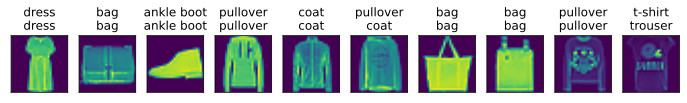

In [ ]:
b =0
for X, y in test_iter:
  b+=1
  if b == 3:
    break

# the functions "get_fashion_mnist_labels" and "show_fashion_mnist" are defined above in this notebook
true_labels = get_fashion_mnist_labels(y.detach().numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).detach().numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

show_fashion_mnist(X[10:20], titles[10:20])

# Concise Implementation of Softmax Regression

Just as PyTorch made it much easier to implement linear regression, we'll find it similarly (or possibly more)
convenient for implementing classification models. Again, we begin with our import ritual.

In [ ]:
import sys
sys.path.insert(0, '..')
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np


Let's stick with the Fashion-MNIST dataset and keep the batch size at $256$ as in the last section.

In [ ]:
batch_size = 256

# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = torchvision.transforms.ToTensor() 
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

In [ ]:
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

## Initialize Model Parameters

As mentioned in `chapter_softmax`, the output layer of softmax regression is a fully connected (`Linear`) layer. Therefore, to implement our model, we just need to add one `Linear` layer with 10 outputs to our `Sequential`. Again, here, the `Sequential` isn't really necessary, but we might as well form the habit since it will be ubiquitous when implementing deep models. Again, we initialize the weights at random with zero mean and standard deviation 0.01.

In [ ]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,784)
    
net = nn.Sequential(Reshape(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## The Softmax

We'll want to keep the conventional softmax function handy
in case we ever want to evaluate the probabilities output by our model.
But instead of passing softmax probabilities into our new loss function,
we'll just pass $\hat{y}$ and compute the softmax and its log
all at once inside the softmax_cross_entropy loss function:

In [ ]:
loss = nn.CrossEntropyLoss()

## Optimization Algorithm

We use the mini-batch random gradient descent
with a learning rate of $0.1$ as the optimization algorithm.
Note that this is the same choice as for linear regression
and it illustrates the general applicability of the optimizers.

## Training

Next, we use the training functions defined in the last section to train a model.

In [ ]:
num_epochs = 10
lr = 0.1

optimizer = torch.optim.SGD(net.parameters(), lr) 

for epoch in range(num_epochs): 
  train_loss_epoch = 0.0
  net.train()
  for X, y in train_iter:  
    y_hat = net(X)
    l = loss(y_hat, y)
    train_loss_epoch += l
    optimizer.zero_grad() 
    l.backward() 
    optimizer.step() 
  train_loss_epoch /= len(train_iter)
  
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    for X_test, y_test in test_iter:
      b_l = loss(net(X_test), y_test) 
      test_loss_epoch += b_l
    test_loss_epoch /= len(test_iter)  
  print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss_epoch, test_loss_epoch)) 

epoch 1, train loss 0.7843029499053955, test loss 0.6259291768074036
epoch 2, train loss 0.5706149935722351, test loss 0.5680242776870728
epoch 3, train loss 0.5242127180099487, test loss 0.5349026322364807
epoch 4, train loss 0.5004078149795532, test loss 0.5213124752044678
epoch 5, train loss 0.4871976375579834, test loss 0.5103784799575806
epoch 6, train loss 0.47421517968177795, test loss 0.5392454862594604
epoch 7, train loss 0.46508923172950745, test loss 0.5145877003669739
epoch 8, train loss 0.45785272121429443, test loss 0.4847160875797272
epoch 9, train loss 0.4523162543773651, test loss 0.48184794187545776
epoch 10, train loss 0.44634315371513367, test loss 0.47853007912635803


Note that in many cases, PyTorch takes specific precautions
in addition to the most well-known tricks for ensuring numerical stability.
This saves us from many common pitfalls that might befall us
if we were to code all of our models from scratch.

## Prediction

Now that training is complete, our model is ready to classify some images.
Given a series of images, we will compare their actual labels
(first line of text output) and the model predictions
(second line of text output).

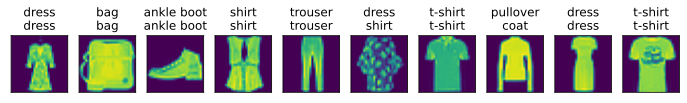

In [ ]:
count = 0
for X, y in test_iter:
  count += 1
  if count == 2:
    break

# the functions "get_fashion_mnist_labels" and "show_fashion_mnist" are defined above in this notebook
true_labels = get_fashion_mnist_labels(y.detach().numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).detach().numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

show_fashion_mnist(X[10:20], titles[10:20])